## Projekt grupowy "Klasyfikacja rodzajów szkła"

Zespół 17:
Maria Mierzejewska, 
Karol Cieślik,
Jakub Matłacz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')

## 1. Wczytanie danych oryginalnych

In [2]:
glass_org = pd.read_csv('glass.csv')
glass_org

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


Oznaczenia klas:<br>
-- 1 building windows float processed<br>
-- 2 building windows non float processed<br> 
-- 3 vehicle windows float processed<br>
-- 4 vehicle windows non float processed (none in this database)<br>
-- 5 containers<br>
-- 6 tableware<br>
-- 7 headlamps

## 2. Sprawdzenie braków danych i rozmiarów ramki

In [12]:
glass_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [13]:
print("Liczba obiektów: ", glass_org.shape[0])
print("Liczba atrybutów włącznie z decyzyjnym: ", glass_org.shape[1])
print("Liczba braków danych:\n", glass_org.isna().sum())

Liczba obiektów:  214
Liczba atrybutów włącznie z decyzyjnym:  10
Liczba braków danych:
 RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64


## 3. Wykresy pudełkowe i skrzypcowe

In [14]:
def pokaz_pudelka(glass):
    plt.figure(figsize=(10,50), dpi= 80)
    plt.subplot(10,1,1)
    sns.boxplot(data=glass.iloc[:,0:-1])
    atrybuty = "RI Na Mg Al Si K Ca Ba Fe".split()
    for i in range(2,11):
        plt.subplot(10,1,i)
        sns.boxplot(x="Type", y=atrybuty[i-2], data=glass)

In [15]:
def pokaz_skrzypce(glass):
    plt.figure(figsize=(10,50), dpi= 80)
    plt.subplot(10,1,1)
    sns.violinplot(data=glass.iloc[:,0:-1])
    atrybuty = "RI Na Mg Al Si K Ca Ba Fe".split()
    for i in range(2,11):
        plt.subplot(10,1,i)
        sns.violinplot(x="Type", y=atrybuty[i-2], data=glass)

Obejrzymy teraz wykresy pudełkowe i skrzypcowe oryginalnych danych:

In [ ]:
pokaz_pudelka(glass_org)

In [ ]:
pokaz_skrzypce(glass_org)

## 4. Macierz korelacji oraz macierz wykresów punktowych

Macierz korelacji Pearsona w celu ewentualnej eliminacji zbędnych atrybutów. Widać, że cecha Ca jest mocno skorelowana z cechą RI jednak nie wystarczająco, aby pominąć jedną z nich.

In [ ]:
sns.heatmap(glass_org.corr(), annot = glass_org.corr())

Macierz wykresów punktowych w celu lepszej wizualizacji zbioru. Widać, że cecha Ba może być dobrym wyznacznikiem przynależności obiektu do klasy 7. Wiele z histogramów przenika się w ogromnym stopniu.

In [ ]:
sns.pairplot(glass_org, kind="scatter", hue = "Type")

## 5. Dystrybucja klas w zbiorze oryginalnym

In [16]:
def class_distr(glass):
    ile_ob_klas = []
    for i in range(1,8):
        ile_ob_klas.append(glass[glass.Type == i].shape[0])
    ile_ob_klas = pd.DataFrame(ile_ob_klas, index=range(1,8), columns=['ilość obiektów'])
    print(ile_ob_klas)
    ile_ob_klas.plot(kind='bar')

   ilość obiektów
1              70
2              76
3              17
4               0
5              13
6               9
7              29


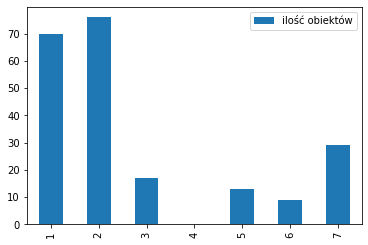

In [17]:
class_distr(glass_org)

Klasa 4 zostanie całkowicie pominięta w następujących rozważaniach i można ją traktować jako nieistniejącą. Z powodu braku jej próbek żaden obiekt nie będzie mógł zostać do niej przypisany. Oryginalny zbiór jest niezbalansowany.

## 6. Testowanie modeli - walidacja krzyżowa StratifiedKFold

Oryginalny zbiór jest niezbalansowany czyli klasy posiadają różną ilość obiektów. Z tego powodu dzieląc zbiór na części uczącą oraz testową należy zadbać o to aby dane były dzielone losowo o ile zawartość klas w obu zbiorach będzie odpowiednia. Dlatego właśnie użyto StratifiedKFold zamiast KFold. Ponadto część uczącą na której będzie trenowany model należy zbalansować metodą oversamplingu SMOTE tak aby wpływ każdej klasy na trenowanie modelu był równy. Ponieważ dane testowe pozostają niezbalansowane to miarą sukcesu testowania będzie precyzja i czułość. Właściwie będą to średnie tych wartości w n iteracjach testowania z różnym podziałem na część uczącą i testową. 

In [18]:
def verify(model, x_learn, y_learn, x_test, y_test):
    #dopasowuje model do podanych danych uczących, testuje i zwraca słownik z informacjami
    model.fit(x_learn, y_learn)
    
    predict_test = model.predict(x_test)
    report = pd.DataFrame(metrics.classification_report(y_test, predict_test, digits=2, output_dict=True))
    
    learn_scores = 1-model.score(x_learn, y_learn)
    test_scores = 1-model.score(x_test, y_test)
    test_prec = report.loc['precision','weighted avg']
    test_rec = report.loc['recall','weighted avg']
    test_f1 = report.loc['f1-score','weighted avg']
    
    return {"learn_scores":learn_scores,"test_scores":test_scores,"test_prec":test_prec,"test_rec":test_rec,"test_f1":test_f1}

In [19]:
def cross_val(model, x, y, n_splits = 9):
    #dokonuje walidacji krzyżowej, za każdym razem oversampluje zbiór uczący i zbiera wszystkie informacje w formie DataFrame
    sm = SMOTE(random_state=3)
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
    all_scores = pd.DataFrame()
    for train_idx, test_idx in kfold.split(x, y):
        x_learn, x_test = x.iloc[train_idx,:], x.iloc[test_idx,:]
        y_learn, y_test = y.iloc[train_idx,:], y.iloc[test_idx,:]
        x_learn_res, y_learn_res = sm.fit_resample(x_learn, y_learn)
        
        scores = pd.DataFrame(verify(model, x_learn_res, y_learn_res, x_test, y_test), index = [0])
        all_scores = all_scores.append(scores)
        
    all_scores.index = range(n_splits)
    return all_scores

In [25]:
def best_knn(max_k, x, y):
    #pomaga dobrać najlepsze k < max_k, dokonuje walidacji krzyżowej dla każdego k i zwraca listę wyników - średnich F1
    wyniki = []
    for i in range(1,max_k+1):
        model = KNeighborsClassifier(n_neighbors=i)
        test_f1 = cross_val(model, x, y).mean()['test_f1']
        wyniki.append(test_f1)
    kwart = pd.DataFrame(wyniki, index=range(1,max_k+1))
    plt.figure(dpi=100)
    plt.plot(kwart,'bo-')
    plt.title('Sprawunek algorytmu kNN')
    plt.xlabel('Liczba sasiadow - k')
    plt.ylabel('Średnie F1')

In [21]:
x = glass_org.iloc[:,:-1]
y = pd.DataFrame(glass_org.iloc[:,-1])

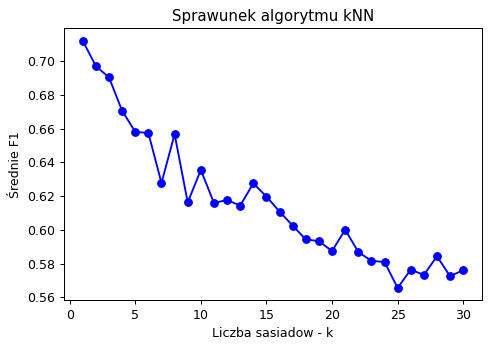

In [23]:
best_knn(30, x, y)

Najlepszym k wydaje się być k=1. 

learn_scores    0.000000
test_scores     0.294485
test_prec       0.757264
test_rec        0.705515
test_f1         0.712158
dtype: float64

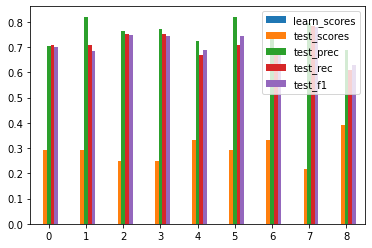

In [26]:
model = KNeighborsClassifier(n_neighbors=1)
score = cross_val(model, x, y)
score.plot.bar(rot = 0)
score.mean()

learn_scores    0.131491
test_scores     0.369364
test_prec       0.676947
test_rec        0.630636
test_f1         0.622059
dtype: float64

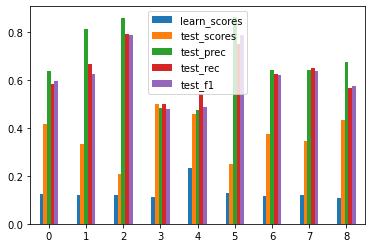

In [30]:
model = tree.DecisionTreeClassifier(max_depth=4)
score = cross_val(model, x, y)
score.plot.bar(rot = 0)
score.mean()

learn_scores    0.334089
test_scores     0.560990
test_prec       0.500817
test_rec        0.439010
test_f1         0.418392
dtype: float64

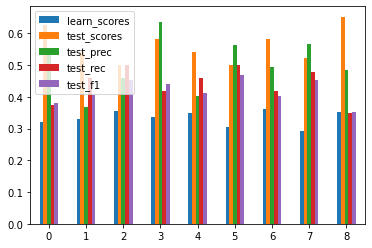

In [28]:
model = NearestCentroid()
score = cross_val(model, x, y)
score.plot.bar(rot = 0)
score.mean()

learn_scores    0.308962
test_scores     0.630233
test_prec       0.493429
test_rec        0.369767
test_f1         0.364962
dtype: float64

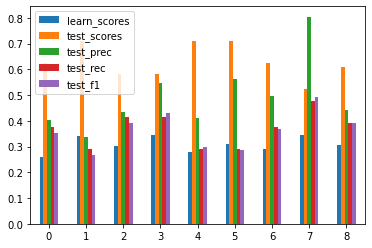

In [29]:
model = GaussianNB()
score = cross_val(model, x, y)
score.plot.bar(rot = 0)
score.mean()